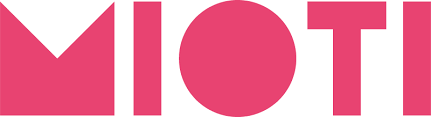

<center style="color:#888">Módulo Advanced Data Science<br/>Natural Language Processing</center>


# 06. Challenge. NER con un modelo Bi-LSTM

In [1]:
import sys
import os
# si estás en google_colab, activa la GPU
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    path_data = 'ner.csv'
    
    if not os.path.exists('.setup_complete'):
        !pip install seqeval[gpu]
        !wget https://www.dropbox.com/s/yy6f13gvnxn2np3/ner.csv.zip
        !unzip ner.csv.zip
        
        !touch .setup_complete
else:
    path_data = 'data/ner.csv.zip'

     |████████████████████████████████| 43 kB 995 kB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=dc6426a7ad5d742af30b8c0347ac6ad935da22377e6e0e70378e4f31e4db9454
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
--2021-11-14 17:14:49--  https://www.dropbox.com/s/yy6f13gvnxn2np3/ner.csv.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.68.18, 2620:100:6023:18::a27d:4312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.68.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/yy6f13gvnxn2np3/ner.csv.zip [following]
--2021-11-14 17:14:50--  https://www.dropbox.com/s/raw/yy6f13gvnxn2np3/ner.csv.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2501140ba8ad40477bb68de64c.dl.dropboxusercontent.com/cd/0/inline/BZ9cuG7y6hiOkd3bZI_

In [2]:
import sys
!{sys.executable} -m pip install -U tensorflow seqeval
!{sys.executable} -m pip install spacy
!{sys.executable} -m pip install plotly

In [3]:
import numpy as np
import pandas as pd
import seqeval
import tensorflow as tf
import gensim
import spacy
from spacy import displacy 
import collections

print(tf.__version__)
print("Debemos trabajar con una versión = 2.4.1")

2.7.0
Debemos trabajar con una versión = 2.4.1


## Dataset
El corpus que vamos a utilizar para el challenge es el *GMB(Groningen Meaning Bank) corpus for named entity classification*.
Puedes encontrar más información en [Kaggle](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus).

In [4]:
dframe = pd.read_csv(path_data,
                     encoding="ISO-8859-1",
                     error_bad_lines=False,
                     index_col=0)
dframe.head()

b'Skipping line 281837: expected 25 fields, saw 34\n'
/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,lemma,next-lemma,next-next-lemma,next-next-pos,next-next-shape,next-next-word,next-pos,next-shape,next-word,pos,prev-iob,prev-lemma,prev-pos,prev-prev-iob,prev-prev-lemma,prev-prev-pos,prev-prev-shape,prev-prev-word,prev-shape,prev-word,sentence_idx,shape,word,tag
0,thousand,of,demonstr,NNS,lowercase,demonstrators,IN,lowercase,of,NNS,__START1__,__start1__,__START1__,__START2__,__start2__,__START2__,wildcard,__START2__,wildcard,__START1__,1.0,capitalized,Thousands,O
1,of,demonstr,have,VBP,lowercase,have,NNS,lowercase,demonstrators,IN,O,thousand,NNS,__START1__,__start1__,__START1__,wildcard,__START1__,capitalized,Thousands,1.0,lowercase,of,O
2,demonstr,have,march,VBN,lowercase,marched,VBP,lowercase,have,NNS,O,of,IN,O,thousand,NNS,capitalized,Thousands,lowercase,of,1.0,lowercase,demonstrators,O
3,have,march,through,IN,lowercase,through,VBN,lowercase,marched,VBP,O,demonstr,NNS,O,of,IN,lowercase,of,lowercase,demonstrators,1.0,lowercase,have,O
4,march,through,london,NNP,capitalized,London,IN,lowercase,through,VBN,O,have,VBP,O,demonstr,NNS,lowercase,demonstrators,lowercase,have,1.0,lowercase,marched,O


## Data preprocessing

El dataframe contiene muchas columnas que no nos interesan, en especial las relativas a palabras anteriores o siguientes. Borramos todas ellas, ya que nuestro modelo tendrá en cuenta el contexto de forma automática. Estas variables serían útiles en caso de hacer **modelos que no tuvieran en cuenta la estructura secuencial de las sentencias**, como por ejemplo regresión logística.


Además, para un NER simple sólo vamos a utilizar la columnas 'word', 'sentence_idx' y 'tag'. Aunque se puede **refinar el algoritmo incluyendo el resto de información**.

**Nota:** Comprueba si existen valores nulos y límpialos acórdemente. 

In [5]:
### ESCRIBE AQUÍ TÚ CÓDIGO

#Visualizamos información del df
print(dframe.info())

#Nos quedamos con las columnas que nos interesan
columnas=['word', 'sentence_idx','tag']
df_clean=dframe[columnas]

#Se revisa si hay nulos
print(df_clean.isnull().sum())

#Como tenemos nulos los eliminamos
df_clean.dropna(axis=0)
print(df_clean.info())
###

df_clean.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1050795 entries, 0 to 1048574
Data columns (total 24 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   lemma            1050795 non-null  object 
 1   next-lemma       1050795 non-null  object 
 2   next-next-lemma  1050795 non-null  object 
 3   next-next-pos    1050795 non-null  object 
 4   next-next-shape  1050795 non-null  object 
 5   next-next-word   1050795 non-null  object 
 6   next-pos         1050795 non-null  object 
 7   next-shape       1050794 non-null  object 
 8   next-word        1050794 non-null  object 
 9   pos              1050794 non-null  object 
 10  prev-iob         1050794 non-null  object 
 11  prev-lemma       1050794 non-null  object 
 12  prev-pos         1050794 non-null  object 
 13  prev-prev-iob    1050794 non-null  object 
 14  prev-prev-lemma  1050794 non-null  object 
 15  prev-prev-pos    1050794 non-null  object 
 16  prev-prev-shape  1

,word,sentence_idx,tag
0,Thousands,1.0,O
1,of,1.0,O
2,demonstrators,1.0,O
3,have,1.0,O
4,marched,1.0,O


In [6]:
assert {'word', 'tag', 'sentence_idx'} == set(df_clean.columns)

# mostramos una sentencia
df_clean[df_clean['sentence_idx'] == 3.0][['word', 'tag']]

,word,tag
54,They,O
55,marched,O
56,from,O
57,the,O
58,Houses,O
59,of,O
60,Parliament,O
61,to,O
62,a,O
63,rally,O


**Agrupamos las sentencias**

Contruimos una lista en el que cada sentencia es un elemento, es decir, agrupamos las palabras que estén en la misma sentencia.

Luego, dibujamos un histograma con la longitud de las sentencias. Para hacer los algoritmos más eficientes, vamos a truncar las sentencias hasta una longitud razonable. 

Guarda ese valor en `MAX_LEN`, **utilizando el cuantil 0.99 de la distribución de longitudes.**

**Pregunta:** ¿Qué problema hay si escogemos un valor de MAX_LEN demasiado pequeño o demasiado grande?

* Si elegimos una longitud de sentencia máxima muy pequeña solo nos vamos a quedar con frases muy pequeñas del tipo 'así que', 'es decir' que no aportan ningún tipo de información

In [7]:
df_clean.shape

(1050795, 3)

In [8]:
def aggregate_sentences(df):
    agg_func = lambda s: [(w, t) for w, t in zip(s["word"].values.tolist(), s[
        "tag"].values.tolist())]
    sentences = [s for s in df.groupby("sentence_idx").apply(agg_func)]

    return sentences


sentences = aggregate_sentences(df_clean)

Maximum sequence length: 74
Minimum sequence length: 1
MAX_LEN (99% quantile): 76


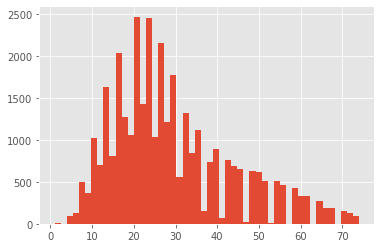

In [9]:
# calcula una lista con la longitud de cada una de las sentencias y MAX_LEN

### ESCRIBE AQUÍ TU CÓDIGO
largo=[len(sentence) for sentence in sentences]
MAX_LEN=int(np.quantile(largo,0.99))
lens=[l for l in largo if l<MAX_LEN]
#Se dejan sólo las frases con un tamaño inferior al MAX_LEN
sentences=[sentence for sentence in sentences if len(sentence)<MAX_LEN]
###

print('Maximum sequence length:', max(lens))
print('Minimum sequence length:', min(lens))

print(f'MAX_LEN (99% quantile): {MAX_LEN}')

import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.hist(lens, bins=50)
plt.show()

In [10]:
# checks

assert isinstance(MAX_LEN, int), '`MAX_LEN` debe ser un entero'
assert 60 < MAX_LEN < 120

## Feature engineering 

### Construimos los diccionarios de palabras y etiquetas.

**Nota:** Añade al diccionario de palabras el token `'#PAD#'`, ya que lo utilizaremos para el padding posteriormente.

In [11]:
### ESCRIBE AQUÍ TU CÓDIGO

#Se crea una lista con las palabras y otra con los tags

words=[[w for w,t in s] for s in sentences]+[['#PAD#']]
tags=[[t for w,t in s] for s in sentences]

#Se generan los diccionarios
word2idx=gensim.corpora.Dictionary(words)
tag2idx=gensim.corpora.Dictionary(tags)
word2idx={v: k for k, v in word2idx.items()}
tag2idx={v: k for k, v in tag2idx.items()}
###

# diccionarios inversos
idx2word = {v: k for k, v in word2idx.items()}
idx2tag = {v: k for k, v in tag2idx.items()}

# número de entradas
n_words = len(word2idx)
n_tags = len(tag2idx)

print(f'Tamaño del vocabulario: {n_words}')
print(f'Número de etiquetas distintas: {n_tags}')

print(f'\nLista de etiquetas:')

#Se saca la lista de tags sin duplicados
tags=[item for lista in tags for item in lista]
tags=set(tags)
tags

Tamaño del vocabulario: 29766
Número de etiquetas distintas: 17

Lista de etiquetas:


{'B-art',
 'B-eve',
 'B-geo',
 'B-gpe',
 'B-nat',
 'B-org',
 'B-per',
 'B-tim',
 'I-art',
 'I-eve',
 'I-geo',
 'I-gpe',
 'I-nat',
 'I-org',
 'I-per',
 'I-tim',
 'O'}

Tenemos las siguientes clases de entidades en un esquema BIO:

- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [12]:
# checks

print(word2idx['Obama'])
print(word2idx['#PAD#'])
print(tag2idx["O"])

2114
29765
2


### Indexado y Padding

Vamos a construir arrays de numpy con los índices, tanto para `X` (las sentencias), como para `y` (las etiquetas de cada token). 

A la hora de entrenar, utilizar batchs estabiliza el entrenamiento, además de que lo hace mucho más rápido. Pero es necesario que en cada batch todos los elementos tengan la misma longitud, para poder construir un array. Por ello, es común realizar un padding de las frases, de tal manera que en el mismo batch todos tienen la misma longitud. 

En nuestro caso, vamos a optar por la opción más simple, que consiste en fijar la longitud de todas las sentencias a `MAX_LEN`. Así podemos guardar todas las sentencias en un array.

Para el padding utilizaremos:
* `X`: el índice del token `'#PAD#'`, 
* `y`: el índice de la etiqueta `'O'`, ya que es en la que no hay ninguna entidad.

Utiliza la función `pad_sequences()` de `keras.preprocessing.sequence`. 

In [13]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

### ESCRIBE AQUÍ TU CÓDIGO
#Se convierte cada documento en una lista de sus índices
X = [[word2idx[w[0]] for w in s] for s in sentences]
#Se rellenan los documentos para que tengan la misma longitud
X = pad_sequences(maxlen=MAX_LEN, sequences=X, value=word2idx['#PAD#'],padding="post")

#Se convierten los tags en índices
y = [[tag2idx[w[1]] for w in s] for s in sentences]
#Se rellenan 
y = pad_sequences(maxlen=MAX_LEN, sequences=y, value=tag2idx["O"],padding="post")

###

In [14]:
# checks

assert isinstance(X, np.ndarray)
assert X.dtype == np.dtype('int32')
assert isinstance(y, np.ndarray)
assert y.dtype == np.dtype('int32')
assert X.shape == y.shape
assert y.shape[0] == len(sentences)
assert y.shape[1] == MAX_LEN

for i, sen in enumerate(sentences):
    if len(sen) < MAX_LEN:
        assert X[i][-1] == word2idx['#PAD#']
        assert y[i][-1] == tag2idx["O"]
        break

Además, necesitamos convertir las etiquetas a *one-hot encoding*, esto se hace de manera muy sencilla con la función `to_categorical()`.

In [15]:
from tensorflow.keras.utils import to_categorical
y = np.array([to_categorical(i, num_classes=n_tags) for i in y])

In [16]:
# hacemos el split entre conjunto de entrenamiento validación y test

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state = 0,
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state = 0,
)

## Modelo

Utilizaremos un modelo de Bi-LSTM en keras. Lo más importante es notar que estamos trabajando con secuencias, y que en general estas tendrán longitud arbitraria.

Vamos a utilizar como features el índice de las palabras únicamente, aunque se puede de forma sencilla expandir, con features adicionales el `'shape'` de la palabra, o utilizar word embeddings pre-entrenados.

<img src="https://neuralner.files.wordpress.com/2018/08/word_level_ner.png?w=660" style="height: 300px">

In [17]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Concatenate

In [18]:
def create_model(input_len=None, emb_dim=256, lstm_units=100):
    input_ = Input(shape=(input_len, ))
    x = Embedding(input_dim=n_words,
                  output_dim=emb_dim,
                  input_length=input_len)(input_)
    x = Dropout(0.1)(x)
    x = Bidirectional(
        LSTM(units=lstm_units, return_sequences=True,
             recurrent_dropout=0.1))(x)
    out = TimeDistributed(Dense(n_tags, activation="softmax"))(
        x)  # softmax output layer
    model = Model(input_, out)
    return model

In [19]:
model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         7620096   
                                                                 
 dropout (Dropout)           (None, None, 256)         0         
                                                                 
 bidirectional (Bidirectiona  (None, None, 200)        285600    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, None, 17)         3417      
 ibuted)                                                         
                                                                 
Total params: 7,909,113
Trainable params: 7,909,113
Non-train

In [20]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

Como ya sabemos, métricas clásicas de clasificación no son informativas en el caso de un problema de NER, necesitamos métricas específicas, en la que se le de importancia a las entidades, y no a la etiqueta `'O'`.

In [21]:
history = model.fit(X_train,
                    y_train,
                    batch_size=512,
                    epochs=10,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
44/44 [==============================] - 41s 783ms/step - loss: 0.7688 - accuracy: 0.9154 - val_loss: 0.2986 - val_accuracy: 0.9409
Epoch 2/10
44/44 [==============================] - 34s 767ms/step - loss: 0.2566 - accuracy: 0.9408 - val_loss: 0.2159 - val_accuracy: 0.9409
Epoch 3/10
44/44 [==============================] - 34s 774ms/step - loss: 0.1840 - accuracy: 0.9451 - val_loss: 0.1608 - val_accuracy: 0.9516
Epoch 4/10
44/44 [==============================] - 34s 763ms/step - loss: 0.1453 - accuracy: 0.9544 - val_loss: 0.1376 - val_accuracy: 0.9569
Epoch 5/10
44/44 [==============================] - 34s 776ms/step - loss: 0.1210 - accuracy: 0.9630 - val_loss: 0.1133 - val_accuracy: 0.9702
Epoch 6/10
44/44 [==============================] - 34s 767ms/step - loss: 0.0915 - accuracy: 0.9768 - val_loss: 0.0861 - val_accuracy: 0.9785
Epoch 7/10
44/44 [==============================] - 34s 765ms/step - loss: 0.0673 - accuracy: 0.9831 - val_loss: 0.0715 - val_accuracy: 0.9813

## Evaluación

Para las métricas de evaluación, nos fijaremos en el **micro averaged F1-score**, ya que nos da un balance entre lo bueno que es asignando las etiquetas correctamente vs. lo bueno que es encontrando las entidades.

Para calcular esta métrica específica de NER, vamos a utilizar la librería `seqeval`, que nos proporciona funciones que podemos utilizar directamente sobre las listas de etiquetas.

Debes convertir tanto `y_test` como `y_pred`, que están en formato *one-hot encoding* a sus respectivas etiquetas de texto. Guarda los resultados en `y_test_tags` e `y_pred_tags`.

In [22]:
from seqeval.metrics import classification_report

In [23]:
y_pred = model.predict(X_test)
print(y_pred.shape)

### ESCRIBE AQUÍ TU CÓDIGO
#Función para hacer la inversa al one hot encoding
def inversa_one_hot(sentence):
    #Se crea una lista para guardar las listas de documentos
    out=[]
    #Se recorren los documentos
    for sent in sentence:
        #Se crea una lista para incluir los tags
        out_s=[]
        #Se recorren los valores numéricos
        for s in sent:
            s_r = np.argmax(s)
            #Se añade a la lista el tag que le corresponde por su índice
            out_s.append(idx2tag[s_r])
        #Se introducen las listas en la lista out
        out.append(out_s)
    return out

y_pred_tags = inversa_one_hot(y_pred)
y_test_tags = inversa_one_hot(y_test)

###

(6954, 76, 17)


In [24]:
# checks

assert len(y_pred_tags) == len(y_test_tags)
assert isinstance(y_pred_tags[0][0], str)
assert isinstance(y_test_tags[0][0], str)
assert set(tag2idx.keys()) >= {tag for sen in y_pred_tags for tag in sen}
assert set(tag2idx.keys()) >= {tag for sen in y_test_tags for tag in sen}

In [25]:
print(classification_report(y_test_tags, y_pred_tags))

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         art       0.00      0.00      0.00        85
         eve       0.00      0.00      0.00        41
         geo       0.79      0.84      0.81      7168
         gpe       0.93      0.90      0.92      3202
         nat       0.00      0.00      0.00        66
         org       0.60      0.62      0.61      3781
         per       0.65      0.64      0.64      3116
         tim       0.81      0.77      0.79      3906

   micro avg       0.76      0.76      0.76     21365
   macro avg       0.47      0.47      0.47     21365
weighted avg       0.76      0.76      0.76     21365



## Estudios de casos particulares

Puedes explorar casos particulares, para identificar patrones en los que el modelo esté fallando.

In [26]:
sentence_idx = 5060

for idx, tag, pred_tag in zip(X_test[sentence_idx], y_test_tags[sentence_idx],
                              y_pred_tags[sentence_idx]):
    print(idx2word[idx], tag, pred_tag)
    if idx2word[idx] == '#PAD#':
        break

Officials O O
say O O
about O O
60 O O
Taleban B-org B-org
insurgents O O
have O O
been O O
killed O O
in O O
the O O
past B-tim B-tim
three I-tim I-tim
days O O
of O O
fighting O O
in O O
the O O
district O O
of O O
Chora B-geo O
. O O
#PAD# O O


## Extras

Puedes intentar las siguientes mejoras:
* Puedes tunear los hiperparámetros del modelo, intentando maximizar el *f1-score* sobre el conjunto de validación.
* Trabajar con la columna `lemma`, o al menos con las palabras en minúsculas. ¿Qué ventajas e inconvenientes supone esto para detectar entidades?
* Puedes añadir features extras, como el `shape`. Para ello, tendrás que crear otra variable categórica. ¿Por qué esto es interesante?
* Puedes inicializar la layer de `Embedding()` en keras con un embedding pre-entrenado mediante el parámetros `weights`.

### Hiperparametrización.
Se opta por parametrizar el modelo por los siguientes parámetros:
* Batch_size
* número de epochs
* rate de la capa Dropout

In [27]:
from seqeval.metrics import f1_score
#f1_score(y_true, y_pred)

In [28]:
# se hiperparametriza sobre el batch_size con una lista de valores
lista_batches=[32,64,128,512]
lista_history=[]
for batch in lista_batches:
    history=model.fit (X_train,y_train,batch_size=batch,epochs=10,validation_data=(X_val, y_val),verbose=1)
    y_pred = model.predict(X_test)
    y_pred_tags=inversa_one_hot(y_pred)
    y_test_tags=inversa_one_hot(y_test)
    lista_history.append(f1_score(y_test_tags, y_pred_tags))

Epoch 1/10
696/696 [==============================] - 518s 744ms/step - loss: 0.0364 - accuracy: 0.9894 - val_loss: 0.0508 - val_accuracy: 0.9854
Epoch 2/10
696/696 [==============================] - 525s 754ms/step - loss: 0.0251 - accuracy: 0.9921 - val_loss: 0.0526 - val_accuracy: 0.9853
Epoch 3/10
696/696 [==============================] - 514s 738ms/step - loss: 0.0191 - accuracy: 0.9939 - val_loss: 0.0571 - val_accuracy: 0.9854
Epoch 4/10
696/696 [==============================] - 523s 751ms/step - loss: 0.0149 - accuracy: 0.9952 - val_loss: 0.0637 - val_accuracy: 0.9851
Epoch 5/10
696/696 [==============================] - 516s 741ms/step - loss: 0.0118 - accuracy: 0.9962 - val_loss: 0.0653 - val_accuracy: 0.9848
Epoch 6/10
696/696 [==============================] - 514s 738ms/step - loss: 0.0092 - accuracy: 0.9970 - val_loss: 0.0713 - val_accuracy: 0.9846
Epoch 7/10
696/696 [==============================] - 513s 738ms/step - loss: 0.0074 - accuracy: 0.9976 - val_loss: 0.0773 -

In [29]:
for history,batch in zip(lista_history,lista_batches):
    print(f'Con un batch de {batch} el modelo da un f1_score de : {history:.3f}')               

Con un batch de 32 el modelo da un f1_score de : 0.774
Con un batch de 64 el modelo da un f1_score de : 0.766
Con un batch de 128 el modelo da un f1_score de : 0.770
Con un batch de 512 el modelo da un f1_score de : 0.769


In [30]:
data_metricas=pd.DataFrame(lista_history,lista_batches).reset_index()
data_metricas=data_metricas.rename(columns={'index':'batch_size',0:'f1_score'})
data_metricas

,batch_size,f1_score
0,32,0.774034
1,64,0.765813
2,128,0.770458
3,512,0.769289


* Por número de epochs.

In [31]:
# se entrena el modelo con número de epochs = 20
history=model.fit (X_train,y_train,batch_size=512,epochs=20,validation_data=(X_val, y_val),verbose=1)
y_pred = model.predict(X_test)

Epoch 1/20
44/44 [==============================] - 34s 764ms/step - loss: 1.0065e-04 - accuracy: 1.0000 - val_loss: 0.1367 - val_accuracy: 0.9838
Epoch 2/20
44/44 [==============================] - 34s 764ms/step - loss: 1.0097e-04 - accuracy: 1.0000 - val_loss: 0.1371 - val_accuracy: 0.9837
Epoch 3/20
44/44 [==============================] - 34s 767ms/step - loss: 9.8618e-05 - accuracy: 1.0000 - val_loss: 0.1365 - val_accuracy: 0.9838
Epoch 4/20
44/44 [==============================] - 34s 774ms/step - loss: 9.8681e-05 - accuracy: 1.0000 - val_loss: 0.1373 - val_accuracy: 0.9838
Epoch 5/20
44/44 [==============================] - 34s 770ms/step - loss: 9.1532e-05 - accuracy: 1.0000 - val_loss: 0.1383 - val_accuracy: 0.9837
Epoch 6/20
44/44 [==============================] - 34s 771ms/step - loss: 9.4227e-05 - accuracy: 1.0000 - val_loss: 0.1376 - val_accuracy: 0.9837
Epoch 7/20
44/44 [==============================] - 34s 769ms/step - loss: 9.3618e-05 - accuracy: 1.0000 - val_loss: 0

In [32]:
from seqeval.metrics import f1_score
y_pred_tags=inversa_one_hot(y_pred)
y_test_tags=inversa_one_hot(y_test)
resultado=f1_score(y_test_tags, y_pred_tags)
print(f'Después de 20 epochs el f1_score es: {resultado:.3f}')

Después de 20 epochs el f1_score es: 0.767


In [33]:
# se entrena el modelo con un número de epochs de 50
history=model.fit (X_train,y_train,batch_size=512,epochs=50,validation_data=(X_val, y_val),verbose=1)
y_pred = model.predict(X_test)

Epoch 1/50
44/44 [==============================] - 34s 779ms/step - loss: 8.0624e-05 - accuracy: 1.0000 - val_loss: 0.1432 - val_accuracy: 0.9837
Epoch 2/50
44/44 [==============================] - 34s 768ms/step - loss: 8.2628e-05 - accuracy: 1.0000 - val_loss: 0.1425 - val_accuracy: 0.9836
Epoch 3/50
44/44 [==============================] - 34s 764ms/step - loss: 7.0859e-05 - accuracy: 1.0000 - val_loss: 0.1427 - val_accuracy: 0.9838
Epoch 4/50
44/44 [==============================] - 34s 774ms/step - loss: 6.9047e-05 - accuracy: 1.0000 - val_loss: 0.1426 - val_accuracy: 0.9836
Epoch 5/50
44/44 [==============================] - 34s 780ms/step - loss: 7.8203e-05 - accuracy: 1.0000 - val_loss: 0.1425 - val_accuracy: 0.9837
Epoch 6/50
44/44 [==============================] - 34s 770ms/step - loss: 7.5328e-05 - accuracy: 1.0000 - val_loss: 0.1430 - val_accuracy: 0.9836
Epoch 7/50
44/44 [==============================] - 34s 771ms/step - loss: 7.5360e-05 - accuracy: 1.0000 - val_loss: 0

In [34]:
from seqeval.metrics import f1_score
y_pred_tags=inversa_one_hot(y_pred)
y_test_tags=inversa_one_hot(y_test)
resultado=f1_score(y_test_tags, y_pred_tags)
print(f'Después de 50 epochs el f1_score es: {resultado:.3f}')

Después de 50 epochs el f1_score es: 0.767


* Por el rate de la capa dropout

In [35]:
# Se opta por un capa de dropout con rate de 0.3 ( 30 % de neuronas desconectadas)
def create_model(input_len=None, emb_dim=256, lstm_units=100):
    input_ = Input(shape=(input_len, ))
    x = Embedding(input_dim=n_words,
                  output_dim=emb_dim,
                  input_length=input_len)(input_)
    x = Dropout(0.3)(x)
    x = Bidirectional(
        LSTM(units=lstm_units, return_sequences=True,
             recurrent_dropout=0.3))(x)
    out = TimeDistributed(Dense(n_tags, activation="softmax"))(
        x)  # softmax output layer
    model = Model(input_, out)
    return model

In [36]:
# Se crea el nuevo modelo con el cambio del rate a 0.3 en la capa de Dropout
model_B = create_model()

In [37]:
# Se compila el nuevo modelo
model_B.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [38]:
# Se entrena el nuevo modelo
history = model_B.fit(X_train,
                    y_train,
                    batch_size=512,
                    epochs=10,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
44/44 [==============================] - 39s 785ms/step - loss: 0.7369 - accuracy: 0.9172 - val_loss: 0.2951 - val_accuracy: 0.9409
Epoch 2/10
44/44 [==============================] - 34s 771ms/step - loss: 0.2590 - accuracy: 0.9408 - val_loss: 0.2225 - val_accuracy: 0.9409
Epoch 3/10
44/44 [==============================] - 34s 775ms/step - loss: 0.1893 - accuracy: 0.9437 - val_loss: 0.1621 - val_accuracy: 0.9513
Epoch 4/10
44/44 [==============================] - 34s 766ms/step - loss: 0.1452 - accuracy: 0.9550 - val_loss: 0.1347 - val_accuracy: 0.9601
Epoch 5/10
44/44 [==============================] - 34s 773ms/step - loss: 0.1170 - accuracy: 0.9674 - val_loss: 0.1068 - val_accuracy: 0.9731
Epoch 6/10
44/44 [==============================] - 34s 762ms/step - loss: 0.0868 - accuracy: 0.9787 - val_loss: 0.0811 - val_accuracy: 0.9798
Epoch 7/10
44/44 [==============================] - 34s 766ms/step - loss: 0.0653 - accuracy: 0.9837 - val_loss: 0.0686 - val_accuracy: 0.9819

In [39]:
# Se hacen las prediccciones de las tags y se calcula el nuevo f1_score
y_pred = model_B.predict(X_test)
y_pred_tags=inversa_one_hot(y_pred)
y_test_tags=inversa_one_hot(y_test)
resultado_B=f1_score(y_test_tags, y_pred_tags)
print(print(f'Con el rate = 0.3 en la capa de Dropout, el f1_score es: {resultado_B:.3f}'))

Con el rate = 0.3 en la capa de Dropout, el f1_score es: 0.756
None


In [40]:
# Se imprimen por pantalla los resultados totales de la métricas
print(classification_report(y_test_tags, y_pred_tags))

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         art       0.00      0.00      0.00        85
         eve       0.00      0.00      0.00        41
         geo       0.80      0.83      0.81      7168
         gpe       0.93      0.91      0.92      3202
         nat       0.00      0.00      0.00        66
         org       0.59      0.60      0.59      3781
         per       0.65      0.65      0.65      3116
         tim       0.81      0.75      0.78      3906

   micro avg       0.76      0.75      0.76     21365
   macro avg       0.47      0.47      0.47     21365
weighted avg       0.75      0.75      0.75     21365



### Trabajamos con la columna lemma.

Trabajando con la columna lemma para detectar entidades tiene la ventaja de que nos reduce la dimensionalidad del vocabulario con el que trabajamos y por tanto nos hace ganar en rendimiento, obtenemos mayor velocidad de cómputo. Como incoveniente señalaríamos la pérdida de significado por lo que obtendriamos peores métricas.

In [41]:
dframe = dframe.fillna(method="ffill")
dframe.head(20)

print("lemmas únicos en el corpus:", dframe['lemma'].nunique())
print("tags únicos en el corpus:", dframe['tag'].nunique())

lemmas = list(set(dframe["lemma"].values))
#lemmas.append("#PAD#"
num_lemmas = len(lemmas)

tags = list(set(dframe["tag"].values))
num_tags = len(tags)

import plotly.express as px

fig = px.histogram(dframe[~dframe.tag.str.contains("O")], x="tag",color="tag")
fig.show()

lemmas únicos en el corpus: 20243
tags únicos en el corpus: 17


In [42]:
df_clean2=dframe[['lemma','sentence_idx','tag']]
###
mask=df_clean2.isnull().sum(axis=1)>0
df_clean2[-mask]
df_clean2.head()

,lemma,sentence_idx,tag
0,thousand,1.0,O
1,of,1.0,O
2,demonstr,1.0,O
3,have,1.0,O
4,march,1.0,O


In [43]:
assert {'lemma', 'tag', 'sentence_idx'} == set(df_clean2.columns)

# mostramos una sentencia
df_clean2[df_clean2['sentence_idx'] == 3.0][['lemma', 'tag']]

,lemma,tag
54,they,O
55,march,O
56,from,O
57,the,O
58,hous,O
59,of,O
60,parliament,O
61,to,O
62,a,O
63,ralli,O


In [44]:
# Se utiliza la misma función pero simplemente le calculamos ahora con lemma en lugar de word
def aggregate_sentences(df):
    agg_func = lambda s: [(l, t) for l, t in zip(s["lemma"].values.tolist(), s[
        "tag"].values.tolist())]
    sentences = [s for s in df.groupby("sentence_idx").apply(agg_func)]

    return sentences


sentences = aggregate_sentences(df_clean2)

#### Feature engineering: construimos los diccionarios de lemmas y etiquetas.

In [45]:
# lista de listas de las lemmas existentes en los documentos ( sentences) + token añadido a lemmas 
lemmas=[[ lemma for lemma,tag in sentence] for sentence in sentences]+[['#PAD#']]
# lista de listas de las etiquetas existentes en los documentos
tags=[[ tag for lemma,tag in sentence] for sentence in sentences]

In [46]:
#Se generan los diccionarios
# dccionario de lemmas únicos
lemma_dict=gensim.corpora.Dictionary(lemmas)
# diccionario de tags únicos
tag_dict=gensim.corpora.Dictionary(tags)
#diccionarios con índices
lemma2idx={v: k for k, v in lemma_dict.items()}
tag2idx={v: k for k, v in tag_dict.items()}
###

# diccionarios inversos
idx2lemma = {v: k for k, v in lemma2idx.items()}
idx2tag = {v: k for k, v in tag2idx.items()}

# número de entradas
n_lemmas = len(lemma2idx)
n_tags = len(tag2idx)

print(f'Tamaño del vocabulario: {n_lemmas}')
print(f'Número de etiquetas distintas: {n_tags}')

print(f'\nLista de etiquetas:')

#Se saca la lista de tags sin duplicados
tags=[item for lista in tags for item in lista]
tags=set(tags)
tags

Tamaño del vocabulario: 20244
Número de etiquetas distintas: 17

Lista de etiquetas:


{'B-art',
 'B-eve',
 'B-geo',
 'B-gpe',
 'B-nat',
 'B-org',
 'B-per',
 'B-tim',
 'I-art',
 'I-eve',
 'I-geo',
 'I-gpe',
 'I-nat',
 'I-org',
 'I-per',
 'I-tim',
 'O'}

#### Indexado y padding.

In [47]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

### ESCRIBE AQUÍ TU CÓDIGO
# se extraen los índices ( según el vocabulario creado) de las palabras de los documentos y se guarda en una lista de listas
x=[[lemma2idx[lemma[0]] for lemma in sentence]for sentence in sentences]
# se convierte esos documentos de índices: secuencias para que tengan  la mismas longitudes.
# se hace padding con el token o palabra #PAD#
X = pad_sequences(sequences=x, maxlen=MAX_LEN, value=lemma2idx['#PAD#'], padding='post')
# se extraen los índices de las etiquetas de los documentos y se guardan en una lista de listas
# serán las secuencias 
y= [[tag2idx[lemma[1]] for lemma in sentence] for sentence in sentences]
# estas secuencias se convierte a una misma longitud haciendo padding con la etuqueta 'O'
y=pad_sequences(sequences=y,maxlen=MAX_LEN,value=tag2idx['O'],padding='post')


In [48]:
# checks

assert isinstance(X, np.ndarray)
assert X.dtype == np.dtype('int32')
assert isinstance(y, np.ndarray)
assert y.dtype == np.dtype('int32')
assert X.shape == y.shape
assert y.shape[0] == len(sentences)
assert y.shape[1] == MAX_LEN

for i, sen in enumerate(sentences):
    if len(sen) < MAX_LEN:
        assert X[i][-1] == lemma2idx['#PAD#']
        assert y[i][-1] == tag2idx["O"]
        break

In [49]:
from tensorflow.keras.utils import to_categorical
y = np.array([to_categorical(i, num_classes=n_tags) for i in y])

In [50]:
# hacemos el split entre conjunto de entrenamiento validación y test

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state = 0,
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state = 0,
)

#### Modelo

In [51]:
model = create_model()
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 256)         7620096   
                                                                 
 dropout_2 (Dropout)         (None, None, 256)         0         
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 200)        285600    
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, None, 17)         3417      
 tributed)                                                       
                                                                 
Total params: 7,909,113
Trainable params: 7,909,113
Non-tra

In [52]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [53]:
history = model.fit(X_train,
                    y_train,
                    batch_size=512,
                    epochs=10,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
44/44 [==============================] - 39s 787ms/step - loss: 0.7404 - accuracy: 0.9171 - val_loss: 0.3101 - val_accuracy: 0.9397
Epoch 2/10
44/44 [==============================] - 34s 777ms/step - loss: 0.2657 - accuracy: 0.9401 - val_loss: 0.2236 - val_accuracy: 0.9397
Epoch 3/10
44/44 [==============================] - 34s 766ms/step - loss: 0.1929 - accuracy: 0.9450 - val_loss: 0.1727 - val_accuracy: 0.9502
Epoch 4/10
44/44 [==============================] - 34s 772ms/step - loss: 0.1575 - accuracy: 0.9531 - val_loss: 0.1499 - val_accuracy: 0.9552
Epoch 5/10
44/44 [==============================] - 34s 774ms/step - loss: 0.1338 - accuracy: 0.9617 - val_loss: 0.1253 - val_accuracy: 0.9676
Epoch 6/10
44/44 [==============================] - 34s 776ms/step - loss: 0.1072 - accuracy: 0.9721 - val_loss: 0.1019 - val_accuracy: 0.9737
Epoch 7/10
44/44 [==============================] - 34s 769ms/step - loss: 0.0867 - accuracy: 0.9772 - val_loss: 0.0880 - val_accuracy: 0.9767

#### Evaluación

In [54]:
y_pred = model.predict(X_test)
print(y_pred.shape)


(7036, 76, 17)


In [55]:
#Se utilza una función para convertir tanto y_test como y_pred, que están en formato one-hot encoding 
# a sus respectivas etiquetas de texto. 
def inversa_one_hot_B(y_pred):
    
    lista_lista=[]
    for sentence in y_pred:
        lista=[]
        for lemma in sentence:
            # este método de numpy devuelve devuelve los índices de  valores con los valores más altos 
            #de la array.
            sal=(np.argmax(lemma))
            lista.append(idx2tag[sal])
        lista_lista.append(lista)
    return lista_lista

In [56]:
y_pred_tags=inversa_one_hot_B(y_pred)
y_test_tags=inversa_one_hot_B(y_test)

In [57]:
# checks

assert len(y_pred_tags) == len(y_test_tags)
assert isinstance(y_pred_tags[0][0], str)
assert isinstance(y_test_tags[0][0], str)
assert set(tag2idx.keys()) >= {tag for sen in y_pred_tags for tag in sen}
assert set(tag2idx.keys()) >= {tag for sen in y_test_tags for tag in sen}

In [58]:
print(classification_report(y_test_tags, y_pred_tags))

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

         art       0.00      0.00      0.00        68
         eve       0.00      0.00      0.00        71
         geo       0.74      0.82      0.78      7355
         gpe       0.93      0.90      0.91      3433
         nat       0.00      0.00      0.00        39
         org       0.49      0.43      0.46      4111
         per       0.63      0.63      0.63      3355
         tim       0.81      0.73      0.77      4086

   micro avg       0.72      0.71      0.72     22518
   macro avg       0.45      0.44      0.44     22518
weighted avg       0.71      0.71      0.71     22518



In [59]:
from seqeval.metrics import f1_score
f1_score(y_test_tags, y_pred_tags)

0.716289056384335

In [60]:
sentence_idx = 50

for idx, tag, pred_tag in zip(X_test[sentence_idx], y_test_tags[sentence_idx],
                              y_pred_tags[sentence_idx]):
    print(idx2lemma[idx], tag, pred_tag)
    if idx2lemma[idx] == '#PAD#':
        break

the O O
foreign O O
minist O O
of O O
chad B-geo B-geo
has O O
call O O
on O O
wealthi O O
nation O O
to O O
help O O
poor O O
countri O O
reduc O O
poverti O O
and O O
advanc O O
social O O
and O O
econom O O
progress O O
. O O
#PAD# O O


### Añadimos features extras : shape

In [61]:
#Añadimos la columna shape que es la que nos interesa
columnas=['word','sentence_idx','tag','shape']
df_clean_shape=dframe[columnas]

#Se revisa si hay nulos
print(df_clean_shape.isnull().sum())
#Como tenemos nulos los eliminamos
# df_clean_shape=df_clean_shape.dropna(axis=0)
print(df_clean_shape.info())


word            0
sentence_idx    0
tag             0
shape           0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1050795 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   word          1050795 non-null  object 
 1   sentence_idx  1050795 non-null  float64
 2   tag           1050795 non-null  object 
 3   shape         1050795 non-null  object 
dtypes: float64(1), object(3)
memory usage: 40.1+ MB
None


In [62]:
df_clean_shape.shape

(1050795, 4)

In [63]:
def aggregate_sentences(df):
    agg_func = lambda s: [(w,sh,t) for w,sh,t in zip(s["word"].values.tolist(),s[
        "shape"].values.tolist(),s["tag"].values.tolist())]
    sentences = [sentence for sentence in df.groupby("sentence_idx").apply(agg_func)]

    return sentences


sentences_shape = aggregate_sentences(df_clean_shape)
sentences_shape=[sentence for sentence in sentences_shape if len(sentence)<MAX_LEN]

In [64]:
len(sentences_shape)

34768

In [65]:
sentences_shape[0]

[('Thousands', 'capitalized', 'O'),
 ('of', 'lowercase', 'O'),
 ('demonstrators', 'lowercase', 'O'),
 ('have', 'lowercase', 'O'),
 ('marched', 'lowercase', 'O'),
 ('through', 'lowercase', 'O'),
 ('London', 'capitalized', 'B-geo'),
 ('to', 'lowercase', 'O'),
 ('protest', 'lowercase', 'O'),
 ('the', 'lowercase', 'O'),
 ('war', 'lowercase', 'O'),
 ('in', 'lowercase', 'O'),
 ('Iraq', 'capitalized', 'B-geo'),
 ('and', 'lowercase', 'O'),
 ('demand', 'lowercase', 'O'),
 ('the', 'lowercase', 'O'),
 ('withdrawal', 'lowercase', 'O'),
 ('of', 'lowercase', 'O'),
 ('British', 'capitalized', 'B-gpe'),
 ('troops', 'lowercase', 'O'),
 ('from', 'lowercase', 'O'),
 ('that', 'lowercase', 'O'),
 ('country', 'lowercase', 'O'),
 ('.', 'punct', 'O'),
 ('Thousands', 'capitalized', 'O'),
 ('of', 'lowercase', 'O'),
 ('demonstrators', 'lowercase', 'O'),
 ('have', 'lowercase', 'O'),
 ('marched', 'lowercase', 'O'),
 ('through', 'lowercase', 'O'),
 ('London', 'capitalized', 'B-geo'),
 ('to', 'lowercase', 'O'),
 ('p

#### Feature engineering: construimos los diccionarios.

In [66]:
words=[[w for w,sh,t in s] for s in sentences_shape]+[['#PAD#']]

shape=[[sh for w,sh,t in s] for s in sentences_shape]

tags=[[t for w,sh,t in s] for s in sentences_shape]

#Se generan los diccionarios
word2idx=gensim.corpora.Dictionary(words)
shape2idx=gensim.corpora.Dictionary(shape)
tag2idx=gensim.corpora.Dictionary(tags)

word2idx={v: k for k, v in word2idx.items()}
tag2idx={v: k for k, v in tag2idx.items()}
shape2idx={v: k for k, v in shape2idx.items()}

###

# diccionarios inversos
idx2word = {v: k for k, v in word2idx.items()}
idx2shape = {v: k for k, v in shape2idx.items()}
idx2tag = {v: k for k, v in tag2idx.items()}

# número de entradas
n_words = len(word2idx)
n_shapes = len(shape2idx)
n_tags = len(tag2idx)

print(f'Tamaño del vocabulario: {n_words}')
print(f'Tamaño de los shapes: {n_shapes}')
print(f'Número de etiquetas distintas: {n_tags}')

print(f'\nLista de shapes:')

#Se saca la lista de tags sin duplicados
# tags=[item for lista in tags for item in lista]
# tags=set(tags)
shape2idx

Tamaño del vocabulario: 29766
Tamaño de los shapes: 11
Número de etiquetas distintas: 17

Lista de shapes:


{'abbreviation': 7,
 'camelcase': 9,
 'capitalized': 0,
 'contains-hyphen': 5,
 'ending-dot': 8,
 'lowercase': 1,
 'mixedcase': 10,
 'number': 3,
 'other': 4,
 'punct': 2,
 'uppercase': 6}

#### Indexado y padding.

In [67]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
#Se convierte cada documento en una lista de sus índices
X = [[word2idx[element[0]] for element in sentence] for sentence in sentences_shape]
#Se rellenan los documentos para que tengan la misma longitud
X = pad_sequences(maxlen=MAX_LEN, sequences=X, value=word2idx['#PAD#'],padding="post")

#Se convierte cada documento en una lista de los indices de los shapes
X_shape = [[shape2idx[element[1]] for element in sentence] for sentence in sentences_shape]
#Se rellenan los documentos para que tengan la misma longitud. 
#Para completar la dimensión se rellena con el indice de lowecase
X_shape = pad_sequences(maxlen=MAX_LEN, sequences=X_shape, value=shape2idx['lowercase'],padding="post")

#Se convierten los tags en índices
y = [[tag2idx[element[2]] for element in sentence] for sentence in sentences_shape]
#Se rellenan 
y = pad_sequences(maxlen=MAX_LEN, sequences=y, value=tag2idx["O"],padding="post")




In [69]:
from tensorflow.keras.utils import to_categorical
#Convertimos a una variable categorica los y
y = np.array([to_categorical(i, num_classes=n_tags) for i in y])

In [70]:
y[0].shape

(76, 17)

In [71]:
# hacemos el split entre conjunto de entrenamiento validación y test

from sklearn.model_selection import train_test_split
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state = 0,
)

X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(
    X_train_2,
    y_train_2,
    test_size=0.2,
    random_state = 0,
)

In [72]:
#Hacemos el slipt para elconjunto de entrenamiento y test de X_shape
X_train_shape_2, X_test_shape_2, y_train_shape_2, y_test_shape_2 = train_test_split(
    X_shape,
    y,
    test_size=0.2,
    random_state = 0,
)

X_train_shape_2, X_val_shape_2, y_train_shape_2, y_val_shape_2 = train_test_split(
    X_train_shape_2,
    y_train_shape_2,
    test_size=0.2,
    random_state = 0,
)

#### Modelo

In [73]:
def create_new_model(input_len=None, emb_dim_shape=16, emb_dim=256, lstm_units=100):
    input_words = Input(shape=(input_len, ))
    x_words = Embedding(input_dim=n_words,
                  output_dim=emb_dim,
                  input_length=input_len)(input_words)
    x_words = Dropout(0.1)(x_words)
    x_words = Dense(8, activation="relu")(x_words)
    x_words = Model(inputs=input_words, outputs=x_words)

    input_shape = Input(shape=(input_len, ))
    x_shape = Embedding(input_dim=n_words,
                  output_dim=emb_dim_shape,
                  input_length=input_len)(input_shape)
    x_shape = Dropout(0.1)(x_shape)
    x_shape = Dense(8, activation="relu")(x_shape)
    x_shape = Model(inputs=input_shape, outputs=x_shape)

    # aquí hay que concatenar los dos modelos anteriores que representan el multinput
    combined = Concatenate(axis=-1)([x_words.output, x_shape.output])
        
    x = Bidirectional(
        LSTM(units=lstm_units, return_sequences=True,
             recurrent_dropout=0.1))(combined)
    
    out = TimeDistributed(Dense(n_tags, activation="softmax"))(
        x)  # softmax output layer
    model = Model(inputs = [input_words, input_shape], outputs = out)
    return model

In [74]:
model_2 = None
model_2 = create_new_model(input_len=MAX_LEN)
model_2.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 76)]         0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 76)]         0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 76, 256)      7620096     ['input_4[0][0]']                
                                                                                                  
 embedding_4 (Embedding)        (None, 76, 16)       476256      ['input_5[0][0]']                
                                                                                            

In [75]:
model_2.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])


In [76]:
history_2 = model_2.fit(x=[X_train_2,X_train_shape_2],
                    y=y_train_2,
                    batch_size=512,
                    epochs=10,
                    validation_data=([X_val_2,X_val_shape_2], y_val_2),
                    verbose=1)

Epoch 1/10
44/44 [==============================] - 40s 787ms/step - loss: 0.9756 - accuracy: 0.9193 - val_loss: 0.3598 - val_accuracy: 0.9409
Epoch 2/10
44/44 [==============================] - 34s 770ms/step - loss: 0.3412 - accuracy: 0.9408 - val_loss: 0.3202 - val_accuracy: 0.9409
Epoch 3/10
44/44 [==============================] - 34s 768ms/step - loss: 0.2658 - accuracy: 0.9408 - val_loss: 0.1951 - val_accuracy: 0.9413
Epoch 4/10
44/44 [==============================] - 34s 763ms/step - loss: 0.1578 - accuracy: 0.9514 - val_loss: 0.1356 - val_accuracy: 0.9583
Epoch 5/10
44/44 [==============================] - 34s 774ms/step - loss: 0.1181 - accuracy: 0.9660 - val_loss: 0.1019 - val_accuracy: 0.9705
Epoch 6/10
44/44 [==============================] - 34s 767ms/step - loss: 0.0845 - accuracy: 0.9777 - val_loss: 0.0764 - val_accuracy: 0.9802
Epoch 7/10
44/44 [==============================] - 34s 766ms/step - loss: 0.0638 - accuracy: 0.9836 - val_loss: 0.0649 - val_accuracy: 0.9823

#### Evaluación

In [77]:
y_pred_2 = model_2.predict([X_test_2,X_test_shape_2])
print(y_pred_2.shape)

(6954, 76, 17)


In [78]:
#Función para hacer la inversa al one hot encoding
def inversa_one_hot(sentence):
    #Se crea una lista para guardar las listas de documentos
    out=[]
    #Se recorren los documentos
    for sent in sentence:
        #Se crea una lista para incluir los tags
        out_s=[]
        #Se recorren los valores numéricos
        for s in sent:
            s_r = np.argmax(s)
            #Se añade a la lista el tag que le corresponde por su índice
            out_s.append(idx2tag[s_r])
        #Se introducen las listas en la lista out
        out.append(out_s)
    return out

y_pred_tags = inversa_one_hot(y_pred_2)
y_test_tags = inversa_one_hot(y_test_2)

###

In [79]:
# checks

assert len(y_pred_tags) == len(y_test_tags)
assert isinstance(y_pred_tags[0][0], str)
assert isinstance(y_test_tags[0][0], str)
assert set(tag2idx.keys()) >= {tag for sen in y_pred_tags for tag in sen}
assert set(tag2idx.keys()) >= {tag for sen in y_test_tags for tag in sen}

In [80]:
print(classification_report(y_test_tags, y_pred_tags))

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

         art       0.00      0.00      0.00        85
         eve       0.00      0.00      0.00        41
         geo       0.78      0.84      0.81      7168
         gpe       0.93      0.90      0.92      3202
         nat       0.00      0.00      0.00        66
         org       0.55      0.62      0.59      3781
         per       0.68      0.70      0.69      3116
         tim       0.79      0.77      0.78      3906

   micro avg       0.74      0.77      0.76     21365
   macro avg       0.47      0.48      0.47     21365
weighted avg       0.74      0.77      0.76     21365



In [81]:
from seqeval.metrics import f1_score
f1_score(y_test_tags, y_pred_tags)

0.7569893462804022

In [82]:
sentence_idx = 50

for idx,shapeidx, tag, pred_tag in zip(X_test_2[sentence_idx],X_test_shape_2[sentence_idx], y_test_tags[sentence_idx],
                              y_pred_tags[sentence_idx]):
    print(idx2word[idx],idx2shape[shapeidx], tag, pred_tag)
    if idx2word[idx] == '#PAD#':
        break

Krajicek capitalized B-per B-per
celebrates lowercase O O
this lowercase O O
tournament lowercase O O
win lowercase O O
the lowercase O O
same lowercase O O
week lowercase O O
she lowercase O O
celebrated lowercase O O
her lowercase O O
17th number O B-tim
birthday lowercase O O
. punct O O
#PAD# lowercase O O


#### Conclusión

* Aunque los resultados de **F1** del modelo, **0.726051575931232**, nos salen muy similares al de la utilización de solo word o solo lemma, entendemos que se puede afinar más configurando de una mejor forma el modelo multinput. El añadir una segunda feature puede solucionar ciertos casos de ambiguedad donde la palabra pueda pertencer a una tipología de palabra u otra dependiendo de que sea mayuscula o minúscula. O en el caso de que sea mayúscula no lo sea por estar al inicio de la frase sino por que lo necesite al ser un nombre propio, un nombre de una Región, ...etc

### Wordembeddings preentrandos

In [2]:
import sys
if 'google.colab' in sys.modules:
  from google.colab import drive
  drive.mount('/content/drive')

In [3]:
if 'google.colab' in sys.modules:
  import os
  os.chdir("//content/drive/My Drive/MIOTI/NLP/SESION 6 - NER/")


In [5]:
from gensim.models import KeyedVectors
my_wv_embeddings = KeyedVectors.load_word2vec_format('fasttext-sbwc.100k.vec', binary=False)


In [7]:
# from gensim.models import Word2Vec
# # cargamos el modelo
# # new_model = Word2Vec.load('my_model.bin')
# my_wv_embeddings = new_model.wv
print(my_wv_embeddings)
my_wv_embeddings.vectors[0]

array([-0.056264 , -0.22871  ,  0.027447 , -0.13122  , -0.08176  ,
       -0.1081   , -0.061006 , -0.096894 , -0.20028  ,  0.16321  ,
       -0.11994  ,  0.0056531,  0.034626 , -0.076504 ,  0.020693 ,
        0.059038 ,  0.15318  , -0.02663  ,  0.046126 , -0.031091 ,
       -0.21827  ,  0.16855  , -0.04018  , -0.002251 ,  0.071853 ,
       -0.08818  ,  0.16049  , -0.047884 , -0.11879  ,  0.13212  ,
       -0.0043661,  0.053813 ,  0.057986 ,  0.1301   , -0.022847 ,
       -0.17716  , -0.0052963,  0.083291 ,  0.017973 ,  0.049088 ,
        0.061659 , -0.02031  , -0.054368 ,  0.020781 ,  0.075574 ,
        0.18046  , -0.067154 , -0.077138 ,  0.11907  ,  0.065576 ,
        0.10459  , -0.031954 ,  0.012681 ,  0.14561  , -0.10621  ,
       -0.15732  ,  0.1147   , -0.26089  ,  0.074254 ,  0.12979  ,
        0.022635 , -0.1069   ,  0.078139 ,  0.080742 , -0.079828 ,
        0.03637  ,  0.095781 , -0.061655 ,  0.069226 , -0.057339 ,
       -0.026284 , -0.066344 , -0.0086231,  0.088817 ,  0.0775

In [8]:
len(my_wv_embeddings.vectors)

100000

In [9]:
my_wv_embeddings.vector_size

300

* El tamaño de los embedding es de 300 mientras que el de nuestras secuencias de 76 vamos a crear una lista nueva con los embedding recortando su tamaño, luego hacemos un diccionario con las palabras y sus embedding correspondientes

In [129]:
#Lista de vectores con los valores de los embedding recortados
embedding=[]
for i in range(len(my_wv_embeddings.vectors)):
    vector=my_wv_embeddings.vectors[i][:MAX_LEN]
    embedding.append(vector)

In [133]:
#Lista de palabras de los embedding
words=[w for w in my_wv_embeddings.vocab]
words[:100]

['de',
 'la',
 '</s>',
 'el',
 'en',
 'y',
 'que',
 '0',
 'a',
 'los',
 'del',
 'las',
 'se',
 'por',
 'un',
 'con',
 'para',
 'una',
 'su',
 'al',
 'no',
 'es',
 'como',
 'más',
 'lo',
 'o',
 'sus',
 'sobre',
 'ha',
 'fue',
 'este',
 'entre',
 'también',
 'pero',
 'esta',
 'años',
 'sin',
 'dos',
 'parte',
 'son',
 'le',
 'han',
 'desde',
 'si',
 'general',
 'estados',
 'ser',
 'está',
 'ya',
 'estado',
 'hasta',
 'e',
 'cuando',
 'durante',
 'año',
 'contra',
 'todos',
 'desarrollo',
 'así',
 'comisión',
 'gobierno',
 'otros',
 'tiene',
 'todo',
 'donde',
 'países',
 'derechos',
 'internacional',
 'naciones',
 'artículo',
 'nacional',
 'consejo',
 'muy',
 'unidas',
 'personas',
 'presidente',
 'puede',
 'grupo',
 'era',
 'después',
 'según',
 'seguridad',
 'país',
 'además',
 'había',
 'uno',
 'gran',
 'tres',
 'programa',
 'trabajo',
 'ese',
 'vez',
 'cada',
 'ciudad',
 'primera',
 'hay',
 'sido',
 'miembros',
 'información',
 'otras']

In [134]:
#Diccionario de palabras con sus vectores correspondientes
dict_embedding={}
for i in range(len(words)):
    dict_emb={words[i]:embedding[i]}
    dict_embedding.update(dict_emb)
dict_embedding

{'de': array([-0.056264 , -0.22871  ,  0.027447 , -0.13122  , -0.08176  ,
        -0.1081   , -0.061006 , -0.096894 , -0.20028  ,  0.16321  ,
        -0.11994  ,  0.0056531,  0.034626 , -0.076504 ,  0.020693 ,
         0.059038 ,  0.15318  , -0.02663  ,  0.046126 , -0.031091 ,
        -0.21827  ,  0.16855  , -0.04018  , -0.002251 ,  0.071853 ,
        -0.08818  ,  0.16049  , -0.047884 , -0.11879  ,  0.13212  ,
        -0.0043661,  0.053813 ,  0.057986 ,  0.1301   , -0.022847 ,
        -0.17716  , -0.0052963,  0.083291 ,  0.017973 ,  0.049088 ,
         0.061659 , -0.02031  , -0.054368 ,  0.020781 ,  0.075574 ,
         0.18046  , -0.067154 , -0.077138 ,  0.11907  ,  0.065576 ,
         0.10459  , -0.031954 ,  0.012681 ,  0.14561  , -0.10621  ,
        -0.15732  ,  0.1147   , -0.26089  ,  0.074254 ,  0.12979  ,
         0.022635 , -0.1069   ,  0.078139 ,  0.080742 , -0.079828 ,
         0.03637  ,  0.095781 , -0.061655 ,  0.069226 , -0.057339 ,
        -0.026284 , -0.066344 , -0.0086231

In [135]:
#Revisamos que los valores coinciden
my_wv_embeddings['quijote'][:76]==dict_embedding['quijote']

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

* A continuación creamos la matriz de incrustación de palabras para cada palabra en el índice obtenido anteriormente. Si la palabra no tiene embedding se presenta como una matriz de ceros

In [136]:
#Creamos la matriz de embedding
embedding_matrix=np.zeros((len(word2idx)+1,MAX_LEN))
for word,i in word2idx.items():
    embedding_vector=dict_embedding.get(word)
    if embedding_vector is not None:
        embedding_matrix[i]=embedding_vector
embedding_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

* Después se utiliza la incrustación como pesos para una capa de keras

In [137]:
embedding_layer = Embedding(input_dim=len(word2idx) + 1,
                            output_dim=MAX_LEN,
                            weights=[embedding_matrix],
                            input_length=MAX_LEN,
                            trainable=False)

* Definimos el modelo y lo compilamos

In [138]:
def create_model(input_len=None, emb_dim=256, lstm_units=100):
    input_ = Input(shape=(input_len, ))
    x = embedding_layer(input_)
    x = Dropout(0.1)(x)
    x = Bidirectional(
        LSTM(units=lstm_units, return_sequences=True,
             recurrent_dropout=0.1))(x)
    out = TimeDistributed(Dense(n_tags, activation="softmax"))(
        x)  # softmax output layer
    model = Model(input_, out)
    return model

In [139]:
model_emb=None
model_emb = create_model()
model_emb.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_5 (Embedding)     (None, None, 76)          2262292   
                                                                 
 dropout_5 (Dropout)         (None, None, 76)          0         
                                                                 
 bidirectional_4 (Bidirectio  (None, None, 200)        141600    
 nal)                                                            
                                                                 
 time_distributed_4 (TimeDis  (None, None, 17)         3417      
 tributed)                                                       
                                                                 
Total params: 2,407,309
Trainable params: 145,017
Non-train

In [140]:
model_emb.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

* Separamos los conjuntos en entrenamiento y test

In [141]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state = 0,
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state = 0,
)

* Entrenamos el modelo

In [142]:
history = model_emb.fit(X_train,
                    y_train,
                    batch_size=512,
                    epochs=10,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
44/44 [==============================] - 37s 745ms/step - loss: 0.8543 - accuracy: 0.9217 - val_loss: 0.3672 - val_accuracy: 0.9409
Epoch 2/10
44/44 [==============================] - 32s 724ms/step - loss: 0.3537 - accuracy: 0.9408 - val_loss: 0.3415 - val_accuracy: 0.9409
Epoch 3/10
44/44 [==============================] - 32s 736ms/step - loss: 0.3204 - accuracy: 0.9408 - val_loss: 0.2832 - val_accuracy: 0.9409
Epoch 4/10
44/44 [==============================] - 32s 735ms/step - loss: 0.2657 - accuracy: 0.9408 - val_loss: 0.2528 - val_accuracy: 0.9409
Epoch 5/10
44/44 [==============================] - 32s 725ms/step - loss: 0.2495 - accuracy: 0.9408 - val_loss: 0.2438 - val_accuracy: 0.9409
Epoch 6/10
44/44 [==============================] - 32s 716ms/step - loss: 0.2422 - accuracy: 0.9408 - val_loss: 0.2370 - val_accuracy: 0.9409
Epoch 7/10
44/44 [==============================] - 32s 724ms/step - loss: 0.2360 - accuracy: 0.9409 - val_loss: 0.2315 - val_accuracy: 0.9409

* Se separan los conjuntos de entrenamiento y prueba

In [143]:
y_pred = model_emb.predict(X_test)
print(y_pred.shape)

y_pred_tags = inversa_one_hot(y_pred)
y_test_tags = inversa_one_hot(y_test)

(6954, 76, 17)


In [144]:
assert len(y_pred_tags) == len(y_test_tags)
assert isinstance(y_pred_tags[0][0], str)
assert isinstance(y_test_tags[0][0], str)
assert set(tag2idx.keys()) >= {tag for sen in y_pred_tags for tag in sen}
assert set(tag2idx.keys()) >= {tag for sen in y_test_tags for tag in sen}

In [145]:
print(classification_report(y_test_tags, y_pred_tags))

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

         art       0.00      0.00      0.00        85
         eve       0.00      0.00      0.00        41
         geo       0.41      0.12      0.19      7168
         gpe       0.00      0.00      0.00      3202
         nat       0.00      0.00      0.00        66
         org       0.00      0.00      0.00      3781
         per       0.04      0.00      0.00      3116
         tim       0.00      0.00      0.00      3906

   micro avg       0.39      0.04      0.07     21365
   macro avg       0.06      0.02      0.02     21365
weighted avg       0.14      0.04      0.06     21365

